## Word Embeddings

Goal: Implement a simple word embedding in Python (from scratch) and use it to find the most similar words to a given word. Come up with a dataset and evaluation metrics to evaluate the word embeddings.

In [19]:
import time
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

### Downloading NLTK's stopwords

In [2]:
import nltk
# nltk.download("stopwords") # Uncomment this line to download the stopwords
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
print(stopwords)

{'had', 'your', 'you', 'the', 'having', 'my', 'he', 'where', 'off', 'such', 'isn', 'all', 'for', 'shan', 'him', 'been', 'm', 'was', "aren't", 'yourself', "wasn't", 'mightn', 'yours', 'up', 'mustn', 'itself', "weren't", 'most', 'same', 'wouldn', 'down', 'll', "wouldn't", 're', 'themselves', 'does', 'are', "hadn't", 'then', 'when', 'or', "isn't", 'each', 'under', 'did', 'be', 'those', 'because', 'can', 'theirs', 'we', 'against', 'through', 'were', 'whom', 't', 'once', 'am', 'me', 'should', "doesn't", 'ma', 'other', 'just', "you'll", 'aren', 'after', 'her', 'herself', "it's", 've', 'myself', 'in', 'at', 'these', 'have', 'before', 'who', 'y', 'don', 'very', 'hers', 'they', 'but', 'by', 'here', 'no', 'hadn', "shouldn't", 's', 'is', 'our', 'that', 'it', 'again', 'of', "should've", 'how', 'doesn', 'out', 'o', 'do', 'being', "you'd", 'd', "won't", 'over', 'both', "you've", 'their', 'she', 'yourselves', 'nor', 'few', 'will', 'between', 'couldn', 'and', "mustn't", 'why', 'some', 'below', 'with',

### Downloading Brown Corpus

The Brown Corpus was the first million-word electronic corpus of English, created in 1961 at Brown University. This corpus contains text from 500 sources, and the sources have been categorized by genre, such as news, editorial, and so on.

In [3]:
# nltk.download("brown") # Uncomment this line to download the brown corpus
from nltk.corpus import brown

In [4]:
# Show the categories of the brown corpus 
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [5]:
# Get the sentences from the "fiction" category
sentences = brown.sents(categories="fiction")

# Number of sentences
print(f"Number of sentences: {len(sentences)}")

# Print the first 5 sentences
for i in range(5):
    print(f"Sentence {i}: {sentences[i]}")

Number of sentences: 4249
Sentence 0: ['Thirty-three']
Sentence 1: ['Scotty', 'did', 'not', 'go', 'back', 'to', 'school', '.']
Sentence 2: ['His', 'parents', 'talked', 'seriously', 'and', 'lengthily', 'to', 'their', 'own', 'doctor', 'and', 'to', 'a', 'specialist', 'at', 'the', 'University', 'Hospital', '--', 'Mr.', 'McKinley', 'was', 'entitled', 'to', 'a', 'discount', 'for', 'members', 'of', 'his', 'family', '--', 'and', 'it', 'was', 'decided', 'it', 'would', 'be', 'best', 'for', 'him', 'to', 'take', 'the', 'remainder', 'of', 'the', 'term', 'off', ',', 'spend', 'a', 'lot', 'of', 'time', 'in', 'bed', 'and', ',', 'for', 'the', 'rest', ',', 'do', 'pretty', 'much', 'as', 'he', 'chose', '--', 'provided', ',', 'of', 'course', ',', 'he', 'chose', 'to', 'do', 'nothing', 'too', 'exciting', 'or', 'too', 'debilitating', '.']
Sentence 3: ['His', 'teacher', 'and', 'his', 'school', 'principal', 'were', 'conferred', 'with', 'and', 'everyone', 'agreed', 'that', ',', 'if', 'he', 'kept', 'up', 'with', '

In [6]:
# Filter out non-alphanumeric words and convert to lowercase
filtered_sentences = []

for sent in sentences:
    filtered_sent = [word.lower() for word in sent if word.isalnum()]
    filtered_sentences.append(filtered_sent)

# Print the first 5 sentences
for i in range(5):
    print(f"Filtered sentence {i}: {filtered_sentences[i]}")

Filtered sentence 0: []
Filtered sentence 1: ['scotty', 'did', 'not', 'go', 'back', 'to', 'school']
Filtered sentence 2: ['his', 'parents', 'talked', 'seriously', 'and', 'lengthily', 'to', 'their', 'own', 'doctor', 'and', 'to', 'a', 'specialist', 'at', 'the', 'university', 'hospital', 'mckinley', 'was', 'entitled', 'to', 'a', 'discount', 'for', 'members', 'of', 'his', 'family', 'and', 'it', 'was', 'decided', 'it', 'would', 'be', 'best', 'for', 'him', 'to', 'take', 'the', 'remainder', 'of', 'the', 'term', 'off', 'spend', 'a', 'lot', 'of', 'time', 'in', 'bed', 'and', 'for', 'the', 'rest', 'do', 'pretty', 'much', 'as', 'he', 'chose', 'provided', 'of', 'course', 'he', 'chose', 'to', 'do', 'nothing', 'too', 'exciting', 'or', 'too', 'debilitating']
Filtered sentence 3: ['his', 'teacher', 'and', 'his', 'school', 'principal', 'were', 'conferred', 'with', 'and', 'everyone', 'agreed', 'that', 'if', 'he', 'kept', 'up', 'with', 'a', 'certain', 'amount', 'of', 'work', 'at', 'home', 'there', 'was', 

In [7]:
# Filter out stopwords and non-alphanumeric words and convert to lowercase
filtered_stopwords_sentences = []

for sent in filtered_sentences:
    filtered_sent = [word.lower() for word in sent if word.isalnum() and word.lower() not in stopwords]
    filtered_stopwords_sentences.append(filtered_sent)

# Print the first 5 sentences
for i in range(5):
    print(f"Filtered sentence {i}: {filtered_stopwords_sentences[i]}")

Filtered sentence 0: []
Filtered sentence 1: ['scotty', 'go', 'back', 'school']
Filtered sentence 2: ['parents', 'talked', 'seriously', 'lengthily', 'doctor', 'specialist', 'university', 'hospital', 'mckinley', 'entitled', 'discount', 'members', 'family', 'decided', 'would', 'best', 'take', 'remainder', 'term', 'spend', 'lot', 'time', 'bed', 'rest', 'pretty', 'much', 'chose', 'provided', 'course', 'chose', 'nothing', 'exciting', 'debilitating']
Filtered sentence 3: ['teacher', 'school', 'principal', 'conferred', 'everyone', 'agreed', 'kept', 'certain', 'amount', 'work', 'home', 'little', 'danger', 'losing', 'term']
Filtered sentence 4: ['scotty', 'accepted', 'decision', 'indifference', 'enter', 'arguments']


### Word2Vec Word Embedding

#### Skip-gram model

In Skip-Gram, the goal is to predict the context words $w_c$ given a target word $w_t$. 

##### Original using softmax

In [8]:
from collections import defaultdict

# Build vocabulary index
def build_vocab(sentences):
    word_count = defaultdict(int)

    for sent in sentences:
        for word in sent:
            word_count[word] += 1

    word_to_idx = {}
    idx_to_word = {}

    for i, word in enumerate(word_count):
        word_to_idx[word] = i
        idx_to_word[i] = word

    return word_to_idx, idx_to_word, word_count

# One-hot encode a word
def OHE_word(word, word_to_idx):
    x = [0] * len(word_to_idx)
    x[word_to_idx[word]] = 1
    return jnp.array(x)

# Get the context words for a target word in a sentence
def get_context_words(target_idx, sentence, window_size=2):
    start = max(0, target_idx - window_size)
    end = min(len(sentence), target_idx + window_size + 1)

    context_words = []
    for context_idx in range(start, end):
        if context_idx != target_idx:
            context_words.append(sentence[context_idx])
    return context_words

# Generate training data from sentences
def generate_training_data(sentences, word_to_idx, window_size=2):
    X = []
    Y = []

    for sent in sentences:
        for target_idx in range(len(sent)):
            target_word = sent[target_idx]
            context_words = get_context_words(target_idx, sent, window_size)

            for context_word in context_words:
                X.append(OHE_word(target_word, word_to_idx))
                Y.append(OHE_word(context_word, word_to_idx))

    X = jnp.array(X)
    Y = jnp.array(Y)

    return X, Y

# Softmax function
def softmax(x):
    return jnp.exp(x) / jnp.sum(jnp.exp(x))

# Forward pass of the neural network
@jax.jit
def net(params, # the list of paramaters
        x,      # a single one-hot encoded word, of correct shape
        ):
    # Initialize the output
    x_out = x

    # Get the layers
    N_layers = len(params)
    for layer_idx in range(N_layers - 1): # Last layer is different
        (A,)  = params[layer_idx]
        x_out = A@x_out

    # Last layer uses softmax
    (A,) = params[-1]
    x_out = softmax(A@x_out)

    return x_out

# Initialize the parameters of the neural network
# Bias terms are not necessary for word embeddings
def init_weights(layer_dims): # (d_in, d1, d2, ..., d_L) -> [(A0,), (A1,), ..., (A_L,)]
    N_layers = len(layer_dims)
    params = []

    for layer_idx in range(N_layers - 1): # Inbetween layers
        # Get the dimensions of the current layer and the next layer
        d_in = layer_dims[layer_idx]
        d_out = layer_dims[layer_idx + 1]

        # Weights should have mean=0 and variance=1/d_in, size = (d_out, d_in)
        A = np.random.normal(0, 1/np.sqrt(d_in), size=(d_out, d_in))

        params.append((A,))
    return params

# Count the number of parameters in the neural network
def count_params(params):
    n_params = 0
    for layer_idx, (A,) in enumerate(params):
        n_params += A.size 
    return n_params

# Forward pass for batch of OHE words
net_batch = jax.jit(jax.vmap(net, in_axes=(None, 0)))

# Cross entropy loss
@jax.jit
def cross_entropy_loss(y, y_pred):
    return -jnp.sum(y * jnp.log(y_pred))

# Loss function for a batch of inputs
@jax.jit
def loss(params, 
         x, # batch inputs
         y # batch outputs
        ):
    y_pred = net_batch(params, x)
    y_pred = y_pred[..., 0]
    return cross_entropy_loss(y, y_pred)

# Compute the value and gradient of the loss function
loss_value_and_grad = jax.jit(jax.value_and_grad(loss))

##### Testing on small data

In [9]:
# Try a small example
word_to_idx, idx_to_word, word_count = build_vocab(filtered_sentences[:2])
vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")

V = vocab_size
E = 2 # Embedding dimension

params = init_weights([V, E, V])

# let us count the number of parameters
print("Number of parameters in the network:", count_params(params))

# Print the shapes of the weights 
for layer_idx, (A,) in enumerate(params):
    print(f"Layer {layer_idx} shape: {A.shape}")

Vocabulary size: 7
Number of parameters in the network: 28
Layer 0 shape: (2, 7)
Layer 1 shape: (7, 2)


In [10]:
X, Y = generate_training_data(filtered_sentences[:2], word_to_idx, window_size=2)

In [11]:
# Single input text
x_in = X[0][..., jnp.newaxis]
print(f'shape of the input: {x_in.shape}')
x_out = net(params, x_in)
print(f'shape of the output: {x_out.shape}')
print(f'output: {x_out}')

shape of the input: (7, 1)
shape of the output: (7, 1)
output: [[0.06635585]
 [0.12693453]
 [0.23136471]
 [0.09541664]
 [0.11540101]
 [0.20822115]
 [0.15630615]]


In [12]:
# Batch input test
x_batch = X[:2]
x_batch = x_batch[..., jnp.newaxis]
print(f'shape of the input: {x_batch.shape}')
net_batch(params, x_batch)

shape of the input: (2, 7, 1)


Array([[[0.06635585],
        [0.12693453],
        [0.23136471],
        [0.09541664],
        [0.11540101],
        [0.20822115],
        [0.15630615]],

       [[0.06635585],
        [0.12693453],
        [0.23136471],
        [0.09541664],
        [0.11540101],
        [0.20822115],
        [0.15630615]]], dtype=float32)

##### Optimise the word embeddings

In [ ]:
# Hyperparameters
window_size = 8

# Build the vocab
sentences = filtered_stopwords_sentences
word_to_idx, idx_to_word, word_count = build_vocab(sentences)
vocab_size = len(word_to_idx)
print(f'Vocabulary size: {vocab_size}')

# Generate training data
X, Y = generate_training_data(sentences, word_to_idx, window_size=window_size)
print(f'X shape: {X.shape}')

N = X.shape[0] # Number of training samples
indices = jnp.arange(N) # Indices of the training samples

In [ ]:
# Hyperparameters
n_epochs = 10
lr = 0.01
embedding_size = 100
batch_size = 128
n_batches = N // batch_size

# Define stopping criteria (loss tolerance)
tolerance = 1e-6

# Initialize the parameters
params = init_weights([vocab_size, embedding_size, vocab_size])
print(f'Number of parameters: {count_params(params)}')

Number of parameters: 31600


In [ ]:
# Track the loss and time
loss_history = []
time_history = []

for epoch in range(n_epochs):
    # shuffle the data
    indices = np.random.permutation(indices)

    # stores all the losses for this epoch
    epoch_losses = []

    # Start the timer
    start_time = time.time()

    for batch in range(n_batches):
        # Get the current batch
        batch_idices = indices[batch*batch_size:(batch+1)*batch_size]
        x_batch = X[batch_idices]
        y_batch = Y[batch_idices]

        # Add a fake last dimension to the input
        x_batch = x_batch[..., jnp.newaxis]

        # Compute the loss and the gradient
        loss_value, grad = loss_value_and_grad(params, x_batch, y_batch)
        epoch_losses.append(loss_value)

        # Update the parameters
        params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, grad)

    # Track the mean loss for each epoch
    mean_epoch_loss = np.mean(epoch_losses)
    loss_history.append(mean_epoch_loss)
    time_history.append(time.time())

    # Check for convergence of loss
    if epoch > 0 and abs(loss_history[-1] - loss_history[-2]) < tolerance:
        print(f"Stopping early at epoch {epoch+1} due to convergence of loss.")
        break

    # Display the loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, loss = {mean_epoch_loss}")

Plots

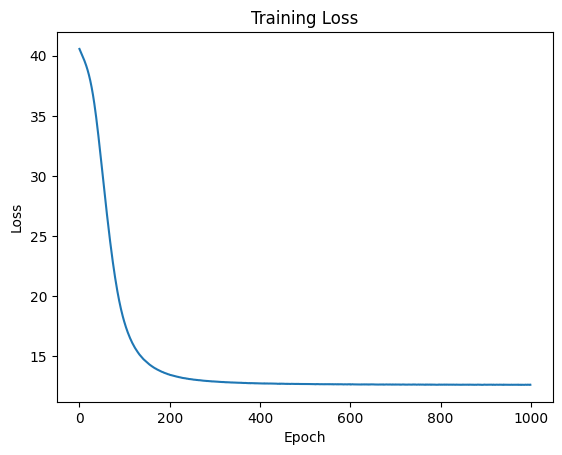

In [ ]:
# Plot the loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

##### Check the embeddings

In [35]:
# Function to get the word embedding of a word
def get_word_embedding(word, word_to_idx, word_embeddings):
    idx = word_to_idx[word]
    return word_embeddings[idx]

# Function to compute the cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    dot_product = jnp.dot(vec1, vec2)
    norm_a = jnp.linalg.norm(vec1)
    norm_b = jnp.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:  # Prevent division by zero
        return 0.0
    return dot_product / (norm_a * norm_b)

# Function to evaluate similarities given a list of word pairs
def evaluate_similarity(word_to_idx, word_embeddings, word_pairs):
    scores = []
    for word1, word2 in word_pairs:
        if word1 in word_to_idx and word2 in word_to_idx:
            vec1 = get_word_embedding(word1, word_to_idx, word_embeddings)
            vec2 = get_word_embedding(word2, word_to_idx, word_embeddings)
            cos_sim = cosine_similarity(vec1, vec2)
            scores.append((word1, word2, cos_sim))
        else:
            print(f"Warning: One of the words '{word1}' or '{word2}' is not in the vocabulary.")
    return scores

In [43]:
word_embeddings = params[0][0].T
print(f"Shape of word embeddings: {word_embeddings.shape}")

# Example word pairs and their expected similarities
word_pairs = [
    ('king', 'queen'),  # Expect high similarity
    ('man', 'woman'),   # Expect high similarity
    ('king', 'man'),    # Moderate similarity
    ('apple', 'fruit'),  # Depending on your vocabulary, could expect a similarity

    ('mother', 'father'),
    ('son', 'daugther'),
    ('father', 'son'),
    ('mother', 'daughter')

]

# Run the evaluation
similarity_scores = evaluate_similarity(word_to_idx, word_embeddings, word_pairs)

# Print results
for word1, word2, sim in similarity_scores:
    print(f"Cosine similarity between '{word1}' and '{word2}': {sim:.4f}")

Shape of word embeddings: (158, 10)
Cosine similarity between 'father' and 'son': -0.2851


In [42]:
word_to_idx

{'scotty': 0,
 'go': 1,
 'back': 2,
 'school': 3,
 'parents': 4,
 'talked': 5,
 'seriously': 6,
 'lengthily': 7,
 'doctor': 8,
 'specialist': 9,
 'university': 10,
 'hospital': 11,
 'mckinley': 12,
 'entitled': 13,
 'discount': 14,
 'members': 15,
 'family': 16,
 'decided': 17,
 'would': 18,
 'best': 19,
 'take': 20,
 'remainder': 21,
 'term': 22,
 'spend': 23,
 'lot': 24,
 'time': 25,
 'bed': 26,
 'rest': 27,
 'pretty': 28,
 'much': 29,
 'chose': 30,
 'provided': 31,
 'course': 32,
 'nothing': 33,
 'exciting': 34,
 'debilitating': 35,
 'teacher': 36,
 'principal': 37,
 'conferred': 38,
 'everyone': 39,
 'agreed': 40,
 'kept': 41,
 'certain': 42,
 'amount': 43,
 'work': 44,
 'home': 45,
 'little': 46,
 'danger': 47,
 'losing': 48,
 'accepted': 49,
 'decision': 50,
 'indifference': 51,
 'enter': 52,
 'arguments': 53,
 'discharged': 54,
 'checkup': 55,
 'described': 56,
 'celebration': 57,
 'lunch': 58,
 'cafeteria': 59,
 'campus': 60,
 'rachel': 61,
 'wore': 62,
 'smart': 63,
 'hat': 64

##### Skip-Gram with Negative Sampling (SGNS)

Negative sampling simplifies this process by approximating the softmax function, 
focusing only on a few context words (positive samples) and a few randomly selected words from the vocabulary (negative samples) instead of the entire vocabulary.

Loss Function: \
The loss function for Skip-Gram with Negative Sampling (SGNS) is typically a binary cross-entropy loss. For each target word $w_t$ and its context words $w_c$, the loss function tries to:
- Maximize the probability that $w_c$ appears in the context of $w_t$
- Minimize the probability that randomly selected (negative) words appear in the context

The loss function is
$$ L = - \left[ \sum_{w_c \in \text{context}} \log \sigma \left( \langle v_{w_c}, v_{w_t} \rangle \right) 
             +  \sum_{w_n \in \text{negatives}} \log \sigma \left( \langle -v_{w_n}, v_{w_t} \rangle \right) \right] $$

where 
- $v_{w_t}$ is the embedding vector of target word $w_t$
- $v_{w_c}$ is the embedding vector of context word $w_c$
- $v_{w_n}$ is the embedding vector of negative word $w_n$ 
- $\sigma(x)$ is the sigmoid function $\sigma(x) = \frac{1}{1 + e^{-x}}$ 

##### Building Vocabulary

In [ ]:
from collections import defaultdict

# Build vocabulary index
def build_vocab_idx(filtered_sentences):
    vocab_count = defaultdict(int)
    for sentence in filtered_sentences:
        for word in sentence:
            vocab_count[word] += 1
    return {word: idx for idx, (word, _) in enumerate(vocab_count.items())}, vocab_count

vocab_idx, vocab_count = build_vocab_idx(filtered_sentences)
vocab_size = len(vocab_idx)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 8155


##### Generate Context Words & Negative Samples

In [ ]:
# input: target word index in sentence, selected sentence, number of context words
# output: list of context words index linked to vocab_idx, weights
def get_context_words(target_idx, sentence, num_context_words):
    window_size = num_context_words // 2
    
    start = max(0, target_idx - window_size)
    end = min(len(sentence), target_idx + window_size + 1)

    contexts = []
    weights = []

    for i in range(start, end):
        if i != target_idx:
            contexts.append(vocab_idx[sentence[i]])
            weights.append(1/abs(i-target_idx))
    while len(contexts) < num_context_words:
        contexts.append(vocab_size)
    while len(weights) < num_context_words:
        weights.append(vocab_size)
    
    return contexts, weights


# input: target word index in vocab_idx, number of unique words, number of negative samples, contexts output of get_context_words()
# output: list of negative words index linked to vocab_idx
def get_negative_samples(target, vocab_size, num_negative_samples, contexts):
    negative_samples = set()
    
    while len(negative_samples) < num_negative_samples:
        # Sample a random word from the vocabulary
        neg_sample = np.random.randint(0, vocab_size)
        # Ensure it's not the target word or context word
        if neg_sample != target and neg_sample not in contexts:
            negative_samples.add(neg_sample)
    
    return list(negative_samples)

##### Gradient Descent & Backtracking Line Search

In [ ]:
def grad_descent(fn, initial_lr, beta, eta, W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights):
    # Convert to array for it to work with jit.vmap
    batch_targets = jnp.array(batch_targets)
    batch_contexts = jnp.array(batch_contexts)
    batch_neg_samples = jnp.array(batch_neg_samples)
    batch_weights = jnp.array(batch_weights)
    
    # Get initial loss and gradient
    initial_loss = fn(W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)
    gradients = jax.grad(fn, argnums=(0, 1))(W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)

    # Backtracking line search
    # Descent Direction for W_in and W_out
    d_in, d_out = -gradients[0], -gradients[1]
    lr = initial_lr

    while True:
        new_W_in = W_in + lr * d_in
        new_W_out = W_out + lr * d_out
        new_loss = fn(new_W_in, new_W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)
        
        # Check if the new loss meets the sufficient decrease condition
        # Exit loop if condition is met
        if new_loss <= initial_loss + eta * lr * (jnp.sum(gradients[0] * d_in) + jnp.sum(gradients[1] * d_out)):
            break

        # Reduce alpha if condition is not met
        lr *= beta

    # Update embeddings
    W_in += lr * d_in
    W_out += lr * d_out

    return W_in, W_out

##### Loss Function

In [ ]:
# input: W_in, W_out, target word index in vocab_idx, contexts & weights output of get_context_words(), 
#   negative_samples output of get_negative_samples()
# output: loss value
@jax.jit
def SGNS_single_loss_fn(W_in, W_out, target, contexts, negative_samples, weights):
    # Get word embeddings
    target_embedding = W_in[target]

    pos_loss = 0
    neg_loss = 0
    
    # Positive score
    for idx, i in enumerate(contexts):
        weight = weights[idx]
        context_embedding = W_out[i]
        positive_score = jnp.dot(context_embedding, target_embedding)
        # Add 1e-10 to prevent log underflow
        pos_loss += jnp.log(jax.nn.sigmoid(positive_score) + 1e-10) * weight

    # Negative scores and loss
    for j in negative_samples:
        negative_embedding = W_out[j]
        negative_scores = jnp.dot(-negative_embedding, target_embedding)
        # Add 1e-10 to prevent log underflow
        neg_loss += jnp.log(jax.nn.sigmoid(negative_scores) + 1e-10)

    # Total loss is the sum of positive loss and negative loss
    return -(pos_loss + neg_loss)

SGNS_loss_batched = jax.jit(jax.vmap(SGNS_single_loss_fn, in_axes=(None, None, 0, 0, 0, 0)))

@jax.jit
def SGNS_batched_loss_fn(W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights):
    individual_losses = SGNS_loss_batched(W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)
    return jnp.mean(individual_losses)

SGNS_batched_loss_fn_jit = jax.jit(SGNS_batched_loss_fn)

##### Model Training

In [ ]:
# hyperparameters
embedding_dim = 100
num_negative_samples = 5
num_context_words = 4
num_epoch = 10
batch_size = 128

initial_lr = 1.0
beta = 0.5
eta = 0.1

# Initiate W_in (for target) and W_out (for context and negative words) matrix
# Add a 0 row in last row for target words with less than number of context words required e.g words as start & end of sentence
W_in = jax.random.normal(jax.random.PRNGKey(0), (vocab_size, embedding_dim)) * 0.01
W_in = jnp.vstack([W_in, jnp.zeros((1, embedding_dim))])
W_out = jax.random.normal(jax.random.PRNGKey(1), (vocab_size, embedding_dim)) * 0.01
W_out = jnp.vstack([W_out, jnp.zeros((1, embedding_dim))])

context_dict = {}
weight_dict = {}

for epoch in range(num_epoch):
    # Initiate for batch
    batch_targets, batch_contexts, batch_neg_samples, batch_weights = [], [], [], []
    for sentence in filtered_stopwords_sentences:
        for target_idx, word in enumerate(sentence):
            target = vocab_idx[word]
            
            # Save context words and weights for future epoch
            if epoch > 0:
                contexts = context_dict[target]
                weights = weight_dict[target]
            else:
                contexts, weights = get_context_words(target_idx, sentence, num_context_words)
                context_dict[target] = contexts
                weight_dict[target] = weights

            # Get negative words
            negative_samples = get_negative_samples(target, vocab_size, num_negative_samples, contexts)

            # Add target, context, negative_samples, weights for batch
            # Batch Targets Shape: (batch_size,)
            batch_targets.append(target)
            # Batch Contexts Shape: (batch_size, num_context_words)
            batch_contexts.append(contexts)
            # Batch Negative Samples Shape: (batch_size, num_negative_samples)
            batch_neg_samples.append(negative_samples)
            # Batch Weights Shape: (batch_size, num_context_words)
            batch_weights.append(weights)

            if len(batch_targets) == batch_size:
                W_in, W_out = \
                    grad_descent(SGNS_batched_loss_fn_jit, initial_lr, beta, eta,\
                        W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)

                # Reset batches
                batch_targets, batch_contexts, batch_neg_samples, batch_weights = [], [], [], []
    
    # Include last few words not enough to form batch
    if len(batch_targets) != 0:
        W_in, W_out = \
            grad_descent(SGNS_batched_loss_fn_jit, initial_lr, beta, eta,\
                W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)

##### Model Testing

In [ ]:
import jax.numpy as jnp

# Function to compute cosine similarity using JAX
def cosine_similarity(vec1, vec2):
    dot_product = jnp.dot(vec1, vec2)
    norm_a = jnp.linalg.norm(vec1)
    norm_b = jnp.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:  # Prevent division by zero
        return 0.0
    return dot_product / (norm_a * norm_b)

# Example word pairs and their expected similarities
word_pairs = [
    ('king', 'queen'),  # Expect high similarity
    ('man', 'woman'),   # Expect high similarity
    ('king', 'man'),    # Moderate similarity
    ('apple', 'fruit'),  # Depending on your vocabulary, could expect a similarity
]

# Function to evaluate similarities using W_out
def evaluate_similarity(vocab_idx, W_out, word_pairs):
    scores = []
    for word1, word2 in word_pairs:
        if word1 in vocab_idx and word2 in vocab_idx:
            vec1 = W_out[vocab_idx[word1]]  # Get the output embedding for word1
            vec2 = W_out[vocab_idx[word2]]  # Get the output embedding for word2
            cos_sim = cosine_similarity(vec1, vec2)
            scores.append((word1, word2, cos_sim))
        else:
            print(f"Warning: One of the words '{word1}' or '{word2}' is not in the vocabulary.")
    
    return scores

# Run the evaluation
similarity_scores = evaluate_similarity(vocab_idx, W_out, word_pairs)

# Print results
for word1, word2, sim in similarity_scores:
    print(f"Cosine similarity between '{word1}' and '{word2}': {sim:.4f}")

Cosine similarity between 'king' and 'queen': 0.7433
Cosine similarity between 'man' and 'woman': 0.8463
Cosine similarity between 'king' and 'man': -0.8466


# Ignore

#####  Skip-Gram with Hierarchical Softmax

Hierarchical Softmax is an alternative to Negative Sampling, where the softmax function is approximated using a binary tree. The loss function is structured similarly to SGNS but involves traversing the binary tree structure and computing a conditional probability at each node.

In this case, the loss function minimizes the difference between the predicted probability and the actual label for each word pair, traversing the tree for each prediction. The key idea is to reduce the computational complexity of softmax when dealing with a large vocabulary.

#### Continuous Bag of Words (CBOW) model

In CBOW, the objective is to predict the target word ​$w_t$ given the context words $w_c$. 

#####  CBOW with Negative Sampling


The model takes the average of the context word embeddings and tries to predict the target word. The loss function for CBOW with Negative Sampling is also binary cross-entropy but formulated slightly differently due to the averaging of context word embeddings.

The loss function is
$$ L = - \left[ \log \sigma \left( \langle v_{w_t}, v_C \rangle \right) 
             +  \sum_{w_n \in \text{negatives}} \log \sigma \left( \langle -v_{w_n}, v_C \rangle \right) \right] $$  
where 
$$ v_C = \frac{1}{|C|} \sum_{w_c \in C} v_{w_c} $$

##### Loss Function

In [ ]:
# input: W_in, W_out, target word index in vocab_idx, contexts & weights output of get_context_words(), 
#   negative_samples output of get_negative_samples()
# output: loss value
@jax.jit
def CBOW_single_loss_fn(W_in, W_out, target, contexts, negative_samples, weights):
    # Get word embeddings
    target_embedding = W_in[target]

    neg_loss = 0
    
    # Get mean context vector
    context_total = jnp.zeros((1, embedding_dim))
    for idx, i in enumerate(contexts):
        weight = weights[idx]
        context_embedding = W_out[i]
        context_total += weight * context_embedding
    context_mean = context_total/(idx+1)
    
    # Positive score
    positive_score = jnp.dot(context_mean, target_embedding)
    pos_loss = jnp.log(jax.nn.sigmoid(positive_score)) * weight

    # Negative scores and loss
    for j in negative_samples:
        negative_embedding = W_out[j]
        negative_scores = jnp.dot(context_mean, -negative_embedding)
        neg_loss += jnp.log(jax.nn.sigmoid(negative_scores))

    # Total loss is the sum of positive loss and negative loss
    return -(pos_loss + neg_loss)

CBOW_loss_batched = jax.jit(jax.vmap(CBOW_single_loss_fn, in_axes=(None, None, 0, 0, 0, 0)))

@jax.jit
def CBOW_batched_loss_fn(W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights):
    individual_losses = CBOW_loss_batched(W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)
    return jnp.mean(individual_losses)

CBOW_batched_loss_fn_jit = jax.jit(CBOW_batched_loss_fn)

##### Model Training

In [ ]:
# hyperparameters
embedding_dim = 100
num_negative_samples = 5
num_context_words = 4
num_epoch = 10
batch_size = 128

initial_lr = 1.0
beta = 0.5
eta = 0.1

# Initiate W_in (for target) and W_out (for context and negative words) matrix
# Add a 0 row in last row for target words with less than number of context words required e.g words as start & end of sentence
W_in = jax.random.normal(jax.random.PRNGKey(0), (vocab_size, embedding_dim)) * 0.01
W_in = jnp.vstack([W_in, jnp.zeros((1, embedding_dim))])
W_out = jax.random.normal(jax.random.PRNGKey(1), (vocab_size, embedding_dim)) * 0.01
W_out = jnp.vstack([W_out, jnp.zeros((1, embedding_dim))])

context_dict = {}
weight_dict = {}

for epoch in range(num_epoch):
    # Initiate for batch
    batch_targets, batch_contexts, batch_neg_samples, batch_weights = [], [], [], []
    for sentence in filtered_stopwords_sentences:
        for target_idx, word in enumerate(sentence):
            target = vocab_idx[word]
            
            # Save context words and weights for future epoch
            if epoch > 0:
                contexts = context_dict[target]
                weights = weight_dict[target]
            else:
                contexts, weights = get_context_words(target_idx, sentence, num_context_words)
                context_dict[target] = contexts
                weight_dict[target] = weights

            # Get negative words
            negative_samples = get_negative_samples(target, vocab_size, num_negative_samples, contexts)

            # Add target, context, negative_samples, weights for batch
            # Batch Targets Shape: (batch_size,)
            batch_targets.append(target)
            # Batch Contexts Shape: (batch_size, num_context_words)
            batch_contexts.append(contexts)
            # Batch Negative Samples Shape: (batch_size, num_negative_samples)
            batch_neg_samples.append(negative_samples)
            # Batch Weights Shape: (batch_size, num_context_words)
            batch_weights.append(weights)

            if len(batch_targets) == batch_size:
                W_in, W_out = \
                    grad_descent(CBOW_batched_loss_fn_jit, initial_lr, beta, eta,\
                        W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)

                # Reset batches
                batch_targets, batch_contexts, batch_neg_samples, batch_weights = [], [], [], []
    
    # Include last few words not enough to form batch
    if len(batch_targets) != 0:
        W_in, W_out = \
            grad_descent(CBOW_batched_loss_fn_jit, initial_lr, beta, eta,\
                W_in, W_out, batch_targets, batch_contexts, batch_neg_samples, batch_weights)

##### Model Testing

In [ ]:
import jax.numpy as jnp

# Function to compute cosine similarity using JAX
def cosine_similarity(vec1, vec2):
    dot_product = jnp.dot(vec1, vec2)
    norm_a = jnp.linalg.norm(vec1)
    norm_b = jnp.linalg.norm(vec2)
    if norm_a == 0 or norm_b == 0:  # Prevent division by zero
        return 0.0
    return dot_product / (norm_a * norm_b)

# Example word pairs and their expected similarities
word_pairs = [
    ('king', 'queen'),  # Expect high similarity
    ('man', 'woman'),   # Expect high similarity
    ('king', 'man'),    # Moderate similarity
    ('apple', 'fruit'),  # Depending on your vocabulary, could expect a similarity
]

# Function to evaluate similarities using W_out
def evaluate_similarity(vocab_idx, W_out, word_pairs):
    scores = []
    for word1, word2 in word_pairs:
        if word1 in vocab_idx and word2 in vocab_idx:
            vec1 = W_out[vocab_idx[word1]]  # Get the output embedding for word1
            vec2 = W_out[vocab_idx[word2]]  # Get the output embedding for word2
            cos_sim = cosine_similarity(vec1, vec2)
            scores.append((word1, word2, cos_sim))
        else:
            print(f"Warning: One of the words '{word1}' or '{word2}' is not in the vocabulary.")
    
    return scores

# Run the evaluation
similarity_scores = evaluate_similarity(vocab_idx, W_out, word_pairs)

# Print results
for word1, word2, sim in similarity_scores:
    print(f"Cosine similarity between '{word1}' and '{word2}': {sim:.4f}")

Cosine similarity between 'king' and 'queen': -0.0612
Cosine similarity between 'man' and 'woman': 0.0513
Cosine similarity between 'king' and 'man': 0.1846


##### CBOW with Hierarchical Softmax

Like in Skip-Gram, CBOW can also use hierarchical softmax as an alternative to Negative Sampling, traversing a binary tree to approximate the softmax function.

### GloVe: Global Vectors for Word Representation

In [ ]:
corpus = brown.sents(categories="news")

In [ ]:
# lower case all words, remove all punctuations and stop words
def preprocess_sentence(sentence):
    return [word.lower() for word in sentence if word.lower() not in stopwords and word not in punctuation]

corpus_preprocessed = [preprocess_sentence(sentence) for sentence in corpus]
corpus_preprocessed[0]

Building Co-occurrence Matrix

In [ ]:
from collections import defaultdict
import numpy as np

# Window size for Co-occurrence matrix - 2 words before, 2 words after
window_size = 2

# Build co-occurrence matrix
def build_cooccurrence_matrix(corpus_preprocessed, vocab_idx, window_size):
    cooccurrence_matrix = defaultdict(lambda: defaultdict(float))
    
    for sentence in corpus_preprocessed:
        sentence_length = len(sentence)
        for i, word in enumerate(sentence):
            word_idx = vocab_idx[word]
            # Context window
            start = max(0, i - window_size)
            end = min(sentence_length, i + window_size + 1)
            
            for j in range(start, end):
                # Skip target word
                if i != j:
                    context_word = sentence[j]
                    context_word_idx = vocab_idx[context_word]
                    # Increment the co-occurrence count with inverse distance weighting
                    cooccurrence_matrix[word_idx][context_word_idx] += 1.0 / abs(i - j)
    return cooccurrence_matrix

cooccurrence_matrix = build_cooccurrence_matrix(corpus_preprocessed, vocab_idx, window_size)
cooccurrence_matrix[0]

In [ ]:
# hyperparameters
x_max = 100
alpha = 0.75
embedding_dim = 50

# Initialize word vectors and bias
key = jax.random.PRNGKey(0)
v = jax.random.normal(key, (vocab_size, embedding_dim))
key, subkey = jax.random.split(key)
v_tilde = jax.random.normal(subkey, (vocab_size, embedding_dim))
bias = jnp.zeros(vocab_size)
bias_tilde = jnp.zeros(vocab_size)

In [ ]:
# weight function
def f(x):
    return jax.minimum(1.0, (x/x_max)**alpha)

# loss function
def gLove_loss(v, v_tilde, bias, bias_tilde, cooccurrence_matrix):
    loss = 0.0
    for word in cooccurrence_matrix:
        for context_word in cooccurrence_matrix[word]:
            X_ij = cooccurrence_matrix[word][context_word]
            weight = f(X_ij)
            diff = jnp.dot(v[word], v_tilde[context_word]) + bias[word] + bias_tilde[context_word] - jnp.log(X_ij)
            loss += weight * diff**2
    return loss